# Comparing ID3 and CS4.5 Learning Algorithms implemented in Python

## Introduction

### Motivation

In order to deeply understand the concepts involved as well as Compare these Algorithms, 
I will implement them each as a Class in base Python, train them on a sample Dataset and compare their learning rates,
both graphically and with some key metrics (training time, accuracy, further metrics to be determined later).

### Scope 
I will not define basic Concepts such Machine Learning and Decision Trees here.
Finally, I consider the history of these Algorithms out of scope here.

Even though this is not a purely or even predominantly mathematical Project I _will_ introduce the Algorithms briefly,
both in order to improve my own understanding and to provide context.

### Key Concepts

#### Entropy
Having been very well defined elsewhere, I think about __Entropy__ in this specific context 
as the degree to which the varying outcomes of a probabilistic process are unbalanced.

Simply put, a system has maximum entropy when all the outcomes are equally likely 
(think randomly picking a number from 1-100 where each numbers' probability of being chosen is 1%)
and approaches zero entropy as an outcome becomes increasingly certain. 

> Formally: Given a random variable $X$, with possible outcomes $x_{i}$, each with probability $P_{X}(x_{i})$ 
> the entropy $H(X)$ is as follows
> $$ H(x) = P_x(x_i) *  log_b P_x(x_i) $$
> 
>source: [wikipedia](https://en.wikipedia.org/wiki/Entropy_(information_theory))
> 
>the base $b$ is usually set at 2 for this specific case, representing a "choice" between 2 outcomes 

By this Token, the Entropy of picking a random Number between 1-100 can be calculated as


In [2]:
from math import log


probabilities = [.01] * 100
entropy_example = -sum([i * log(.01, 2) for i in probabilities])
entropy_example

6.6438561897747395

graphically, let's look how entropy behaves in the most simple case from maximum to minimum:

We start out with an equal coin toss with likelihood of 50 | 50 (maximum entropy) 
and end up with a perfectly unfair coin toss: 0 | 1

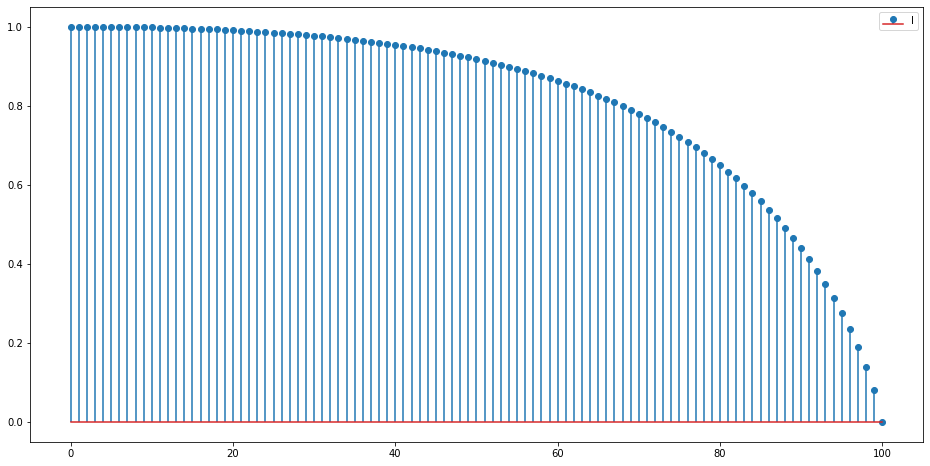

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import entropy


heads = .5
tails = 1 - heads

# we shift the likelihoods over from 0.5 - 0 and calculate entropy at each point
# this time we use the entropy function from scipy
# this could be vectorized with numpy, but at a list of this size...
entropies = [entropy([(heads - i), tails], base=2) for i in [j * 0.005 for j in range(101)]]

plt.figure(figsize=(16,8))
plt.stem(range(101),entropies, use_line_collection=True)
plt.legend('likelihood of a coin toss - from equal to unfair, in steps of 1%')
plt.show()

as we can see, this looks like a classic logarithmic curve

#### Information Gain
Complementary to Entropy of a probabilistic process, Information Gain indicates the decrease of entropy that occurs 
due to knowledge of a specific feature of the process, or makes the outcome of the process more deterministic.

> Formally _the expected information gain is the change in information entropy Η 
> from a prior state to a state that takes some information as given:_
>
> $$ IG(T, a) = H(T) - H(T|a) $$
>
> where $H(T)$ describes the entropy of a system and $H(T|a)$ describes the entropy given and attribute $a$ 
>
> source : [wikipedia](https://en.wikipedia.org/wiki/Information_gain_in_decision_trees)

Informally, my heuristic for information gain is how much a new observation causes models and assumptions to be revised,
the more surprising a new value, the more a model needs to be revised 
and therefore the more information is gained.

More importantly concerning decision trees, information gain can be constructed in terms of 
the effect on entropy of splitting groups along a feature and look at the (posterior, conditional) entropy in the resulting groups 
compared to the prior entropy.
If you're familiar with Bayes' Theorem, this should bring up some memories (fond or otherwise)

> Formally that means we define the conditional entropy of a training set $ T $ given a feature $ a $ - $ H(T|a) $
> as:
>
> $$ \sum_{v \in vals(a)} \frac{|S_a(v)|}{|T|} \cdot H(S_a(v))  $$
>
> here $S_a(v)$ denotes the subset of the training set $T$ for which the feature $a$ is applicable

Ultimately, we calculate the entropy in all resulting subsets, multiply them by the relative sizes of the subsets 
and sum them up. 
So if we split Training group exactly in half on a feature, we calculate the entropy of subgroup a * .5 
and the entropy of subgroup b * .5 and the sum would be our resulting entropy.

To show a more tangible example:

Assuming we have a group of 100 people and know only their height and their gender.
Now we want to find the best "cutoff" height to split the group into male/female. We to this by:
* picking a cutoff height, let's say 170cm and splitting the group in two
* calculate conditional entropy in the group above / below given a height of more or less than 170 cm, respectively
* multiply the conditional entropies by the group sizes (e.g. 35/100 and 65/100) and sum them up
* calculate the difference between the original entropy of the whole set and the sums (the information gain)
* record the information gain and shift the cutoff to the next possible value

In Python:

[1.0,
 0.9999817845368459,
 0.999926399368686,
 0.9998327094582857,
 0.9996995428565172,
 0.9995256892936492,
 0.999309898706868,
 0.9990508797006226,
 0.9987472979361685,
 0.9983977744464616,
 0.9980008838722995,
 0.9975551526153486,
 0.9970590569034107,
 0.9965110207629746,
 0.9959094138937685,
 0.9952525494396791,
 0.9945386816500109,
 0.9937660034246586,
 0.9929326437363043,
 0.9920366649222822,
 0.9910760598382221,
 0.9900487488650184,
 0.9889525767600615,
 0.9877853093429981,
 0.9865446300055644,
 0.9852281360342515,
 0.983833334733701,
 0.9823576393378013,
 0.9807983646944296,
 0.9791527227086764,
 0.9774178175281716,
 0.9755906404527989,
 0.9736680645496202,
 0.9716468389522365,
 0.9695235828220428,
 0.9672947789468945,
 0.9649567669505686,
 0.9625057360840397,
 0.9599377175669783,
 0.9572485764449988,
 0.954434002924965,
 0.9514895031471158,
 0.9484103893488014,
 0.9451917693702084,
 0.9418285354475157,
 0.9383153522334069,
 0.9346466439786693,
 0.9308165808016582,
 0.92681906

## The Iterative Dichotomiser 3 (ID3) Algorithm


